# INF554 Team ==Baseline== Feature Extraction and Model Training
### Francisco, Alex and Aksel

## 1.1 Importing Libraries and Loading the Datasets

In [1]:
import random
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
import seaborn as sns
import os
import networkx as nx
import pdb
import pickle
from collections import Counter
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_extraction import text as fe
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt
import datetime
import time
import keras
import lightgbm
import spacy
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
import nltk
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin

Using TensorFlow backend.


Note: running all of the following feature extraction cells will take a long time. However, after running for the first time the computationally intensive part of the feature is pickled and so can be easily calculated in subsequent runs. Many of the cells (especially in the feature extraction section) will use this technique.

In [2]:
with open(r"training.txt", "r") as f:
    reader = csv.reader(f)
    training  = list(reader)
# in order of training examples
training = [element[0].split(" ") for element in training]
training = pd.DataFrame(training, columns=['Node1', 'Node2', 'Link'])
print("Training examples shape: {}".format(training.shape))

with open(r"testing.txt", "r") as f:
    reader = csv.reader(f)
    testing  = list(reader)
# in order of testing examples
testing = [element[0].split(" ") for element in testing]
testing = pd.DataFrame(testing, columns=['Node1', 'Node2'])
print("Testing examples shape: {}".format(testing.shape))

Training examples shape: (453797, 3)
Testing examples shape: (113450, 2)


In [3]:
# directory to store extracted features
if not os.path.exists(r'pickles'):
    os.mkdir(r'pickles')

In [4]:
'''
load the corpus one file at a time, remove spaces and convert to lower case
'''
NODE_INFO_DIRECTORY = r"node_information/text/"

corpus_path = r"pickles/simple_corpus.PICKLE" 
ids_path = r"pickles/ids.PICKLE"
if os.path.exists(corpus_path):
    with open(corpus_path, 'rb') as f:
        corpus = pickle.load(f)
    f.close()
    with open(ids_path, 'rb') as f:
        ids = pickle.load(f)
    f.close()
else:
    corpus = []
    ids = []
    for filename in tqdm(os.listdir(NODE_INFO_DIRECTORY), position=0, leave=True):
        with open(NODE_INFO_DIRECTORY + filename, 'r', encoding='UTF-8', errors='ignore') as f:
            doc_string = []
            for line in f:
                [doc_string.append(token.strip()) for token in line.lower().strip().split(" ") if token != ""]
            corpus.append(' '.join(doc_string))
            ids.append(filename[:-4])
    with open(corpus_path, '+wb') as f:
        pickle.dump(corpus, f)
    f.close()
    with open(ids_path, '+wb') as f:
        pickle.dump(ids, f)
    f.close() 

In [5]:
# stemmed corpus is created by Preprocessing.ipynb file
stemmed_corpus_path = r"pickles/stemmed_corpus.PICKLE" 
if os.path.exists(stemmed_corpus_path):
    with open(stemmed_corpus_path, 'rb') as f:
        stemmed_corpus = pickle.load(f)
    f.close()
else:
    print('Stemmed corpus unavailable, please run the Preprocessing.ipynb file')

# in order of alphabetical text information i.e. 0, 1, 10, 100
node_info = pd.DataFrame({'id': ids, 'corpus': corpus, 'stemmed': stemmed_corpus})
node_info_id = node_info.set_index(['id'])
print("Training node info shape: {}".format(node_info.shape))

Training node info shape: (33226, 3)


In [6]:
# make graph/ feature extraction split (saved for reproducable results)
train_graph_split_path = 'pickles/train_graph_split_5.PICKLE'

if os.path.exists(train_graph_split_path):
    with open(train_graph_split_path, 'rb') as f:
        keep_indices = pickle.load(f)
    f.close()
else:
    keep_indices = random.sample(range(len(training)), k=int(len(training) * 0.05))
    with open(train_graph_split_path, '+wb') as f:
        pickle.dump(keep_indices, f)
    f.close()

data_train_val = training.iloc[keep_indices]
data_train = training.loc[~training.index.isin(keep_indices)]

In [7]:
linked_nodes = data_train.loc[data_train['Link']=='1']
linked_nodes = linked_nodes[['Node1', 'Node2']]
linked_nodes.to_csv('linked_nodes.txt', sep=' ', index=False, header=False)
G=nx.read_edgelist('linked_nodes.txt', create_using=nx.Graph(), nodetype = str)

In [12]:
# create empty dataframe in which features will be extracted
# dictionary key indexes original training data
perf_val_data = pd.DataFrame(data_train_val.Node1.values, columns = ['Node1'])
perf_val_data['Node2'] = list(data_train_val.Node2.values)
perf_val_data['Link'] =  list(data_train_val.Link.values)
perf_val_data['original_index'] = list(data_train_val.index)

# dictionary key indexes original testing data
perf_test_data = pd.DataFrame(testing.Node1.values, columns = ['Node1'])
perf_test_data['Node2'] = list(testing.Node2.values)
perf_test_data['original_index'] = list(testing.index)

## 1.2 Load Already Extracted Features

In [29]:
feature_vector_path = r"pickles/perf_val_data_final.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        perf_val_data = pickle.load(f)
    f.close()

feature_vector_path = r"pickles/perf_test_data_final.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        perf_test_data = pickle.load(f)
    f.close()

In [92]:
# saving the extracted features (disallows overwriting). This function should be run after all features are computed
feature_vector_path = r"pickles/perf_val_data_final.PICKLE"
if not os.path.exists(feature_vector_path):
    with open(feature_vector_path, '+wb') as f:
        pickle.dump(perf_val_data, f)
    f.close()
feature_vector_path = r"pickles/perf_test_data_final.PICKLE"
if not os.path.exists(feature_vector_path):
    with open(feature_vector_path, '+wb') as f:
        pickle.dump(perf_test_data, f)
    f.close()
    print('Created pickles successfully')

Created pickles successfully


## 2.1 Extracting Text Based Features

In [14]:
EPSILON = 1e-10
n_samples = 2000
n_features = 64

In [17]:
# vectorize corpus into word count matrix
corpus_matrix_path = r"pickles/stemmed_corpus_word_matrix.PICKLE"
if os.path.exists(corpus_matrix_path):
    with open(corpus_matrix_path, 'rb') as f:
        corpus_word_matrix = pickle.load(f)
    f.close()
else:
    vectorizer1 = fe.CountVectorizer()
    corpus_word_matrix = vectorizer1.fit_transform(tqdm(stemmed_corpus, position=0, leave=True))
    with open(corpus_matrix_path, '+wb') as f:
        pickle.dump(corpus_word_matrix, f)
    f.close()

In [18]:
# vectorize corpus according to tfidf methodology
corpus_matrix_path = r"pickles/stemmed_corpus_tfidf_matrix.PICKLE"
if os.path.exists(corpus_matrix_path):
    with open(corpus_matrix_path, 'rb') as f:
        corpus_tfidf_matrix = pickle.load(f)
    f.close()
else:
    vectorizer3 = fe.TfidfVectorizer()
    corpus_tfidf_matrix = vectorizer3.fit_transform(tqdm(stemmed_corpus, position=0, leave=True))
    with open(corpus_matrix_path, '+wb') as f:
        pickle.dump(corpus_tfidf_matrix, f)
    f.close()

In [94]:
# compute cosine similarity between two tfidf vectors
def tfidf_similarity(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    index1 = ids.index(node1)
    index2 = ids.index(node2)
    sim = corpus_tfidf_matrix[index1] @ corpus_tfidf_matrix[index2].T 
    norm = np.linalg.norm(corpus_tfidf_matrix[index1].toarray()) * np.linalg.norm(corpus_tfidf_matrix[index2].toarray())
    return sim.toarray()[0][0] / (norm + EPSILON)
perf_val_data['tfidf_similarity']=list(map(lambda i:tfidf_similarity(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['tfidf_similarity']=list(map(lambda i:tfidf_similarity(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|██████████████████████████████████████████████████████████████████████████| 113450/113450 [47:44<00:00, 39.60it/s]


In [95]:
# reduce vectorized tfidf matrix according to n-dimensional NMF using Frobenius norm
nmf_frobenius_path = r"pickles/stemmed_nmf_frobenius_matrix.PICKLE"
if os.path.exists(nmf_frobenius_path):
    with open(nmf_frobenius_path, 'rb') as f:
        nmf_frobenius = pickle.load(f)
    f.close()
else:
    print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
          "n_samples=%d and n_features=%d..." % (corpus_tfidf_matrix.shape[0], n_features))

    nmf_frobenius = NMF(n_components=n_features, random_state=1, alpha=.1, l1_ratio=.5).fit_transform(corpus_tfidf_matrix)
    
    with open(nmf_frobenius_path, '+wb') as f:
        pickle.dump(nmf_frobenius, f)
    f.close()

In [83]:
# reduce vectorized tfidf matrix according to n-dimensional NMF using Kullback-Leibler divergence
nmf_kd_path = r"pickles/nmf_kd_64_matrix.PICKLE"
if os.path.exists(nmf_kd_path):
    with open(nmf_kd_path, 'rb') as f:
        nmf_kd = pickle.load(f)
    f.close()
else:
    print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
          "tf-idf features, n_samples=%d and n_features=%d..."
          % (corpus_tfidf_matrix.shape[0], n_features))

    nmf_kd = NMF(n_components=n_features, random_state=1,
              beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
              l1_ratio=.5).fit_transform(corpus_tfidf_matrix)

    with open(nmf_kd_path, '+wb') as f:
        pickle.dump(nmf_kd, f)
    f.close()

In [97]:
# reduce vectorized word count matrix according to LDA (Latent Dirichlet Allocation)
lda_path = r"pickles/stemmed_lda_64_matrix.PICKLE"
if os.path.exists(lda_path):
    with open(lda_path, 'rb') as f:
        lda = pickle.load(f)
    f.close()
else:
    print("Fitting LDA models with tf features, "
          "n_samples=%d and n_features=%d..."
          % (corpus_tfidf_matrix.shape[0], n_features))
    lda = LatentDirichletAllocation(n_components=n_features, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0).fit_transform(corpus_word_matrix)

    with open(lda_path, '+wb') as f:
        pickle.dump(lda, f)
    f.close()

In [88]:
# reduce vectorized tfidf matrix according to LSA (Latent Semantic Analysis)
lsa_path = r"pickles/stemmed_lsa_2000_matrix.PICKLE"
if os.path.exists(lsa_path):
    with open(lsa_path, 'rb') as f:
        corpus_lsa_matrix = pickle.load(f)
    f.close()
else:
    print("Performing dimensionality reduction using LSA")
    svd = TruncatedSVD(n_samples)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    corpus_lsa_matrix = lsa.fit_transform(corpus_tfidf_matrix)

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    with open(lsa_path, '+wb') as f:
        pickle.dump(corpus_lsa_matrix, f)
    f.close()

In [19]:
languages_nltk_path = r"pickles/languages_nltk.PICKLE"
if os.path.exists(languages_nltk_path):
    with open(languages_nltk_path, 'rb') as f:
        languages_nltk = pickle.load(f)
    f.close()
else:
    print('language feature unavailable, please run Preprocessing.ipynb file')

In [20]:
langs = {}
for i in languages_nltk:
    lang = str(np.argmax(languages_nltk[i]))
    if lang in langs:
        langs[lang] += 1
    else:
        langs[lang] = 1
list(zip([langs[i] for i in sorted(langs, key=lambda k:int(k))], stopwords.fileids()))

[(1014, 'arabic'),
 (18, 'azerbaijani'),
 (49, 'danish'),
 (115, 'dutch'),
 (9315, 'english'),
 (25, 'finnish'),
 (20916, 'french'),
 (525, 'german'),
 (15, 'greek'),
 (24, 'hungarian'),
 (32, 'indonesian'),
 (234, 'italian'),
 (39, 'kazakh'),
 (273, 'nepali'),
 (38, 'norwegian'),
 (67, 'portuguese'),
 (97, 'romanian'),
 (384, 'russian'),
 (32, 'slovene'),
 (14, 'spanish')]

In [102]:
# compute cosine similarity between two language representation vectors
def languages_nltk_similarity(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    sim = languages_nltk[node1] @ languages_nltk[node2].T / (
        np.linalg.norm(languages_nltk[node1]) * np.linalg.norm(languages_nltk[node2]) + EPSILON)
    return sim

perf_val_data['languages_similarity']=list(map(lambda i:languages_nltk_similarity(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['languages_similarity']=list(map(lambda i:languages_nltk_similarity(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|████████████████████████████████████████████████████████████████████████| 113450/113450 [00:12<00:00, 9300.78it/s]


In [103]:
# compute multiplication of document length, empty documents are severly penalized
def joint_length(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    length = len(node_info_id['stemmed'].loc[node1]) * len(node_info_id['stemmed'].loc[node2])
    return length

perf_val_data['joint_length']=list(map(lambda i:joint_length(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['joint_length']=list(map(lambda i:joint_length(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|████████████████████████████████████████████████████████████████████████| 113450/113450 [00:21<00:00, 5158.48it/s]


In [104]:
# compute the distance between node labels as a proxy for crawl order
def file_distance(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    dist = abs(int(node1) - int(node2))
    return dist

perf_val_data['file_distance']=list(map(lambda i:file_distance(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['file_distance']=list(map(lambda i:file_distance(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|███████████████████████████████████████████████████████████████████████| 113450/113450 [00:05<00:00, 22604.99it/s]


In [105]:
# compute cosine similarity between two Frobenious norm NMF vectors
def nmf_frobenius_similarity(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    index1 = ids.index(node1)
    index2 = ids.index(node2)
    sim = nmf_frobenius[index1] @ nmf_frobenius[index2].T / (
        np.linalg.norm(nmf_frobenius[index1]) * np.linalg.norm(nmf_frobenius[index2]) + EPSILON)
    return sim

perf_val_data['nmf_frobenius_similarity']=list(map(lambda i:nmf_frobenius_similarity(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['nmf_frobenius_similarity']=list(map(lambda i:nmf_frobenius_similarity(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|█████████████████████████████████████████████████████████████████████████| 113450/113450 [04:52<00:00, 387.80it/s]


In [106]:
# compute cosine similarity between two LDA vectors
def lda_similarity(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    index1 = ids.index(node1)
    index2 = ids.index(node2)
    sim = lda[index1] @ lda[index2].T / (
        np.linalg.norm(lda[index1]) * np.linalg.norm(lda[index2]) + EPSILON)
    return sim

perf_val_data['lda_similarity']=list(map(lambda i:lda_similarity(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['lda_similarity']=list(map(lambda i:lda_similarity(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|█████████████████████████████████████████████████████████████████████████| 113450/113450 [03:59<00:00, 473.78it/s]


In [89]:
# compute cosine similarity between two LSA vectors
def lsa_similarity(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    index1 = ids.index(node1)
    index2 = ids.index(node2)
    sim = corpus_lsa_matrix[index1] @ corpus_lsa_matrix[index2].T / (
        np.linalg.norm(corpus_lsa_matrix[index1]) * np.linalg.norm(corpus_lsa_matrix[index2]) + EPSILON)
    return sim

perf_val_data['lsa_similarity']=list(map(lambda i:lsa_similarity(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['lsa_similarity']=list(map(lambda i:lsa_similarity(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|█████████████████████████████████████████████████████████████████████████| 113450/113450 [03:07<00:00, 604.60it/s]


In [84]:
# compute cosine similarity between two Kullback-Leibler divergence NMF vectors
def nmf_kd_similarity(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    index1 = ids.index(node1)
    index2 = ids.index(node2)
    sim = nmf_kd[index1] @ nmf_kd[index2].T / (
        np.linalg.norm(nmf_kd[index1]) * np.linalg.norm(nmf_kd[index2]) + EPSILON)
    return sim

perf_val_data['nmf_kd_similarity']=list(map(lambda i:nmf_kd_similarity(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['nmf_kd_similarity']=list(map(lambda i:nmf_kd_similarity(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|█████████████████████████████████████████████████████████████████████████| 113450/113450 [02:54<00:00, 649.30it/s]


In [90]:
perf_val_data.columns

Index(['Node1', 'Node2', 'Link', 'original_index', 'tfidf_similarity',
       'languages_similarity', 'joint_length', 'file_distance',
       'common_neighbors', 'jaccard_coefficient', 'shortest_path',
       'adamic_adar_index', 'resource_allocation_index',
       'preferential_attachment', 'nmf_frobenius_similarity', 'lda_similarity',
       'katz_index', 'page_rank_alpha.5', 'page_rank_alpha.2',
       'page_rank_alpha.7', 'nmf_kd_similarity', 'lsa_similarity'],
      dtype='object')

## 2.2 Extracting Graph Based Features

In [109]:
# create dictionary of neighbouring nodes
neighborsDict={}
for n in G.nodes():
    neighborsDict[n]= list(G.neighbors(n))  

In [110]:
# calcuate the number of common neighbours between two nodes
def common_neighbors(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        return len(set(neighborsDict[node1]).intersection(neighborsDict[node2]))
    else : 
        return 0

perf_val_data['common_neighbors']=list(map(lambda i:common_neighbors(i, training), 
                                           tqdm(perf_val_data['original_index'], leave=True, position = 0)))
perf_test_data['common_neighbors']=list(map(lambda i:common_neighbors(i, testing), 
                                            tqdm(perf_test_data['original_index'], leave=True, position = 0)))

100%|████████████████████████████████████████████████████████████████████████| 113450/113450 [00:13<00:00, 8246.37it/s]


In [111]:
# compute the Jaccard coefficient for a pair of nodes
def jaccard_coef(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        return [p for u,v,p in nx.jaccard_coefficient(G, [(node1, node2)])][0]
    else:
        return 0

perf_val_data['jaccard_coefficient']=list(map(lambda i:jaccard_coef(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['jaccard_coefficient']=list(map(lambda i:jaccard_coef(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|█████████████████████████████████████████████████████████████████████████| 113450/113450 [02:12<00:00, 853.90it/s]


In [112]:
# find the shortest path between two nodes
def shortest_path(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        try:
            sp=nx.shortest_path(G, node1, node2)
            return len(sp)
        except nx.NetworkXNoPath:
            return 0
    else:
        return 0

perf_val_data['shortest_path']=list(map(lambda i:shortest_path(i, training), 
                                        tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['shortest_path']=list(map(lambda i:shortest_path(i, testing), 
                                         tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|████████████████████████████████████████████████████████████████████████| 113450/113450 [00:53<00:00, 2110.00it/s]


In [113]:
# compute the page rank for each nodes and take the average (alpha = 0.7)
pr = nx.pagerank(G, alpha=0.7)

def page_rank(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        page_rank = (pr[node1] + pr[node2]) / 2
        return page_rank
    else: 
        return 0

perf_val_data['page_rank_alpha.7']=list(map(lambda i:page_rank(i, training), 
                                    tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['page_rank_alpha.7']=list(map(lambda i:page_rank(i, testing), 
                                     tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|███████████████████████████████████████████████████████████████████████| 113450/113450 [00:03<00:00, 30730.71it/s]


In [114]:
# compute the page rank for each nodes and take the average (alpha = 0.5)
pr = nx.pagerank(G, alpha=0.5)

def page_rank(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        page_rank = (pr[node1] + pr[node2]) / 2
        return page_rank
    else: 
        return 0
    
perf_val_data['page_rank_alpha.5']=list(map(lambda i:page_rank(i, training), 
                                    tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['page_rank_alpha.5']=list(map(lambda i:page_rank(i, testing), 
                                     tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|███████████████████████████████████████████████████████████████████████| 113450/113450 [00:03<00:00, 31709.35it/s]


In [115]:
# compute the page rank for each nodes and take the average (alpha = 0.2)
pr = nx.pagerank(G, alpha=0.2)

def page_rank(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        page_rank = (pr[node1] + pr[node2]) / 2
        return page_rank
    else: 
        return 0
    
perf_val_data['page_rank_alpha.2']=list(map(lambda i:page_rank(i, training), 
                                    tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['page_rank_alpha.2']=list(map(lambda i:page_rank(i, testing), 
                                     tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|███████████████████████████████████████████████████████████████████████| 113450/113450 [00:03<00:00, 29371.05it/s]


In [116]:
# calculate the Adamic Adar Index between two nodes
def adamic_adar_index(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        return [p for u,v,p in nx.adamic_adar_index(G, [(node1, node2)])][0]
    else:
        return 0

perf_val_data['adamic_adar_index']=list(map(lambda i:adamic_adar_index(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['adamic_adar_index']=list(map(lambda i:adamic_adar_index(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|█████████████████████████████████████████████████████████████████████████| 113450/113450 [02:08<00:00, 882.24it/s]


In [117]:
# calculate the resource allocation between two nodes
def resource_allocation_index(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        return [p for u,v,p in nx.resource_allocation_index(G, [(node1, node2)])][0]
    else:
        return 0

perf_val_data['resource_allocation_index']=list(map(lambda i:resource_allocation_index(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['resource_allocation_index']=list(map(lambda i:resource_allocation_index(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|█████████████████████████████████████████████████████████████████████████| 113450/113450 [02:04<00:00, 910.11it/s]


In [118]:
# calculate the preferential attachment metric associated with two nodes
def preferential_attachment(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        return [p for u,v,p in nx.preferential_attachment(G, [(node1, node2)])][0]
    else:
        return 0

perf_val_data['preferential_attachment']=list(map(lambda i:preferential_attachment(i, training), 
                                              tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['preferential_attachment']=list(map(lambda i:preferential_attachment(i, testing), 
                                               tqdm(perf_test_data['original_index'], position=0, leave=True)))

100%|███████████████████████████████████████████████████████████████████████| 113450/113450 [00:04<00:00, 23161.11it/s]


In [119]:
# compute the Katz index for every node in the graph
katz_index_path = r"pickles/katz_index.PICKLE"
if os.path.exists(katz_index_path):
    with open(katz_index_path, 'rb') as f:
        ki = pickle.load(f)
    f.close()
else:
    ki = nx.katz_centrality_numpy(G, alpha=0.1, beta=1.0)
    with open(katz_index_path, '+wb') as f:
        pickle.dump(ki, f)
    f.close()

In [77]:
# compute the average Katz index of two nodes
def katz_index(index, dataset):
    node1 = dataset['Node1'][index]
    node2 = dataset['Node2'][index]
    if (node1 in neighborsDict.keys()) and (node2 in neighborsDict.keys()): 
        katz_index_sim = (ki[node1] + ki[node2]) / 2
        return katz_index_sim
    else: 
        return 0
    
perf_val_data['katz_index']=list(map(lambda i:katz_index(i, training), 
                                    tqdm(perf_val_data['original_index'], position=0, leave=True)))
perf_test_data['katz_index']=list(map(lambda i:katz_index(i, testing), 
                                     tqdm(perf_test_data['original_index'], position=0, leave=True)))

  0%|                                                                                        | 0/22689 [00:00<?, ?it/s]


KeyError: '27090'

Note that feature selection is conducted after the classifier has been chosen as the optimal number of features will depend on the model chosen. It is tackled towards the end of section 3.

## 3.1 Training and Model Analysis

In [40]:
'''
a variety of calssifiers were chosen to be trained and assess the performance of the features.
The function below provides a comparison between methods.
The best will then be tuned properly for the appropriate hyperparameters.
'''
def multi_classifier(X_train, X_test, y_train, y_test):
    classifier_names = ['LR', 'SVM', 'RF', 'GBM', 'LGBM', 'BAG', 'KNN']
    metrics = ['F1', 'Accuracy']
    df_summary = pd.DataFrame(np.zeros((len(metrics), len(classifier_names))), 
                              columns = classifier_names, 
                              index = metrics)
    logreg = LogisticRegression()
    svm = SVC()
    rf = RandomForestClassifier()
    gbm = GradientBoostingClassifier()
    lgbm = lightgbm.LGBMClassifier()
    bag = BaggingClassifier()
    knn = KNeighborsClassifier()
    classifiers= [logreg, svm, rf, gbm, lgbm, bag, knn]
    for idx, classifier in enumerate(classifiers): 
        model = classifier.fit(X_train, y_train)
        predictions = model.predict(X_test)    
        f1 = f1_score(y_test, predictions)
        accuracy = accuracy_score(y_test, predictions)
        df_summary.iloc[0,idx]=np.round(f1, 4)
        df_summary.iloc[1,idx]=np.round(accuracy, 4)
    
    return df_summary

In [41]:
# simplified function for testing purposes
def simpler_multi_classifier(X_train, X_test, y_train, y_test):
    classifier_names = ['LR', 'RF','LGBM']
    metrics = ['F1', 'Accuracy']
    df_summary = pd.DataFrame(np.zeros((len(metrics), len(classifier_names))), 
                              columns = classifier_names, 
                              index = metrics)
    logreg = LogisticRegression()
    rf = RandomForestClassifier()
    lgbm = lightgbm.LGBMClassifier()
    classifiers= [logreg, rf, lgbm]
    for idx, classifier in enumerate(classifiers): 
        model = classifier.fit(X_train, y_train)
        predictions = model.predict(X_test)    
        f1 = f1_score(y_test, predictions)
        accuracy = accuracy_score(y_test, predictions)
        df_summary.iloc[0,idx]=np.round(f1, 4)
        df_summary.iloc[1,idx]=np.round(accuracy, 4)
    
    return df_summary

Below the fetures are isolated and passed into the classifier function. Unimportant columns are removed and the data is normalized according to the sklearn standard scaler.

In [31]:
from sklearn.preprocessing import StandardScaler

d_columns = ['original_index', 'Link', 'Node1', 'Node2']
cols = [i for i in perf_val_data.columns if i not in d_columns]
X = perf_val_data[cols]
y = list(map(lambda i: int(i), perf_val_data['Link']))

scaler = StandardScaler()
normalized = scaler.fit_transform(X)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(normalized, y, test_size=0.15, random_state=1)
simpler_multi_classifier(X_train, X_test, y_train, y_test)

C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,LR,RF,LGBM
F1,0.9135,0.932,0.9417
Accuracy,0.8925,0.913,0.9248


In [42]:
'''
iterating through various random initializations of the classifiers to check the range of F1 values that are yielded
'''
errors = np.empty((10,7))
error_list = []

for i in range(10):
    print('Loop number: {}'.format(i+1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    error_list.append(multi_classifier(X_train, X_test, y_train, y_test))
error_df = pd.concat(error_list)

Loop number: 1


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Loop number: 2


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Loop number: 3


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Loop number: 4


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Loop number: 5


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Loop number: 6


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Loop number: 7


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Loop number: 8


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Loop number: 9


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Loop number: 10


C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\fvice\Miniconda3\envs\map572\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


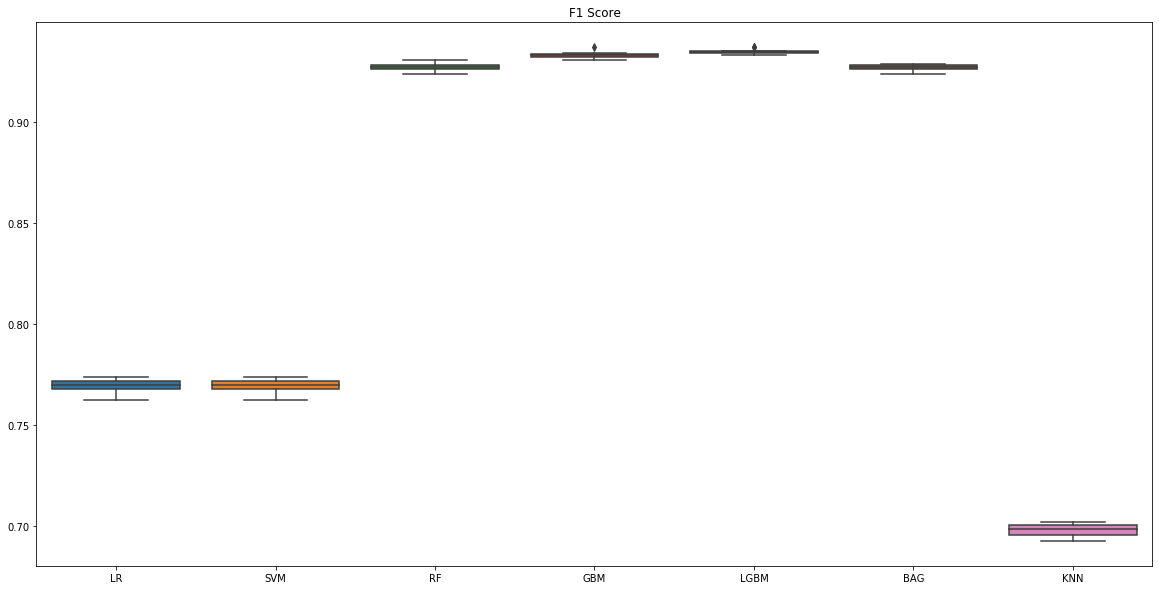

In [48]:
fig, ax = plt.subplots(figsize=(20,10))
x_plot = list(error_df.columns.values) * 10
y_plot = list(error_df.loc['F1'].values.reshape(-1))
sns.boxplot(x_plot, y_plot)
plt.title("F1 Score")
plt.show()

## 3.2 Feature Importance and Selection

In [57]:
X_train, X_test, y_train, y_test = train_test_split(normalized, y, test_size=0.15, random_state=1)

lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, np.round(predictions)))

0.9416590701914312


In [53]:
# use the LGMB method 'feature_importances_' to extract features which are most relevant
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = model_lgbm.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.set_index('feature', inplace=True)

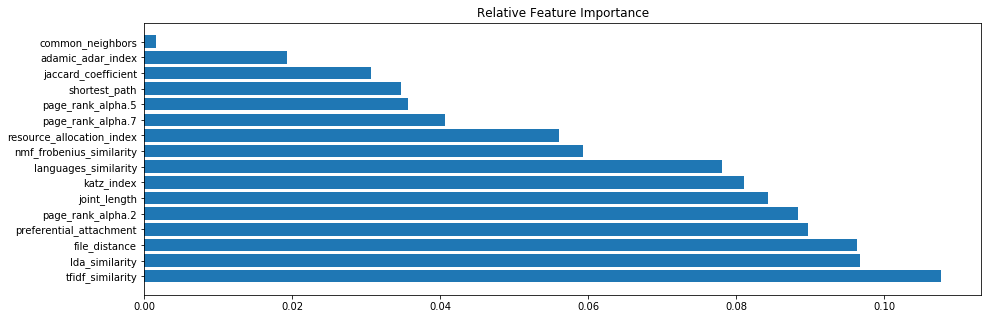

In [54]:
importance = np.array(features.values.reshape(-1))
importance = list(importance/importance.sum(axis=0,keepdims=1))
bars = list(features.index.values)
y_pos = np.arange(len(bars))

fig, ax = plt.subplots(figsize=(15,5))

# Create horizontal bars, and place names of features on the vertical axis
plt.barh(y_pos, importance)
plt.yticks(y_pos, bars)
plt.title("Relative Feature Importance")
plt.show()

In [58]:
# using the RFE to select features by recursively considering smaller and smaller sets of features.
from sklearn.feature_selection import RFE
selector = RFE(lgbm, 10)
selector = selector.fit(normalized, y)
print(selector.support_)
print(selector.ranking_)

[ True  True  True  True False False False False  True  True  True  True
  True False  True False]
[1 1 1 1 7 4 3 6 1 1 1 1 1 2 1 5]


In [75]:
X.columns[selector.support_]

Index(['tfidf_similarity', 'languages_similarity', 'joint_length',
       'file_distance', 'resource_allocation_index', 'preferential_attachment',
       'nmf_frobenius_similarity', 'lda_similarity', 'katz_index',
       'page_rank_alpha.2'],
      dtype='object')

In [72]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train[:, selector.support_], y_train)
predictions = model_lgbm.predict(X_test[:, selector.support_])
print(f1_score(y_test, np.round(predictions)))

0.9397042093287827


## 3.3 Hyperparameter Tuning

In [78]:
# create a suitable F1 score function for hyperopt to use
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    pred_label = np.round(preds)
    f_score = f1_score(pred_label, labels)
    return 'f1_score', f_score, True

def hyperopt(X, y, params):
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=0)
    train_data = lightgbm.Dataset(X_train, label=y_train)
    valid_data = lightgbm.Dataset(X_val, label=y_val)

    # limitting the max depth and feature fraction corresponds to preventing over fitting of the model. 
    # Regularization parameters alpha and lambda also prevent over fitting
    space = {
        "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.5)),
        "max_depth": hp.choice("max_depth", [3, 4, 5, 6, 7]),
        "num_leaves": hp.choice("num_leaves", np.linspace(10, 200, 50, dtype=int)),
        "feature_fraction": hp.quniform("feature_fraction", 0.6, 1.0, 0.1),
        "reg_alpha": hp.uniform("reg_alpha", 0, 2),
        "reg_lambda": hp.uniform("reg_lambda", 0, 2),
        "min_child_weight": hp.uniform('min_child_weight', 0.5, 10),
    }

    def objective(hyperparams):
        model = lightgbm.train({**params, **hyperparams}, train_data, 300, 
                               valid_data, early_stopping_rounds=30, verbose_eval=0, feval = evalerror)

        score = model.best_score["valid_0"]['f1_score']
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, trials=trials,
                algo=tpe.suggest, max_evals=50, verbose=1,
                rstate=np.random.RandomState(1))

    hyperparams = space_eval(space, best)

    print(f"auc = {-trials.best_trial['result']['loss']:0.4f} {hyperparams}")

    return hyperparams


In [79]:
# run the hyperparameter search using a random grid search defined above
params = {
    "objective": "binary",
    "metric": 'f1_score',
    "verbosity": -1,
    "seed": 1,
    "num_threads": 4
}
hyperparams = hyperopt(X, y, params)

100%|██████████████████████████████████████████████████| 50/50 [03:23<00:00,  4.07s/it, best loss: -0.9380989018675245]
auc = 0.9381 {'feature_fraction': 1.0, 'learning_rate': 0.21523775466325193, 'max_depth': 3, 'min_child_weight': 2.2030053794358273, 'num_leaves': 29, 'reg_alpha': 1.9358823758378476, 'reg_lambda': 1.1602834619269524}


## 4.1 Kaggle Prediction using Optimal Hyperparameters

In [80]:
# use the hyperparameters found above to train the final model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

train_data = lightgbm.Dataset(X_train, label=y_train)
valid_data = lightgbm.Dataset(X_test, label=y_test)

model = lightgbm.train({**params, **hyperparams}, train_data, 500,
                       valid_data, early_stopping_rounds=30, verbose_eval=100, feval = evalerror)

predictions = model.predict(X_test)
print(f1_score(y_test, np.round(predictions)))

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	valid_0's f1_score: 0.938584
0.9385841537740272


In [81]:
d_columns = ['original_index', 'Node1', 'Node2']
cols = [i for i in perf_test_data.columns if i not in d_columns]

model = lightgbm.LGBMClassifier(**hyperparams)
model = model.fit(X, y, eval_metric = evalerror)
test = perf_test_data[cols]
predictions = model.predict(test)

In [28]:
final_pred = pd.concat([perf_test_data['original_index'], pd.DataFrame(predictions)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("distance_prediction2.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)

## 4.2 Kaggle Prediction Naive

In [128]:
d_columns = ['original_index', 'Node1', 'Node2']
cols = [i for i in perf_test_data.columns if i not in d_columns]

model = lightgbm.LGBMClassifier()
model = model.fit(X, y)
test = perf_test_data[cols]
predictions = model.predict(test)

In [129]:
final_pred = pd.concat([perf_test_data['original_index'], pd.DataFrame(predictions)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("normalized_prediction_reduced_features.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)

## 5.1 Extra Testing: Augmented Hadmard LDA features

In [55]:
embed_size = 2000
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = (corpus_lsa_matrix[int(data_train_val.loc[i]['Node1'])] * corpus_lsa_matrix[int(data_train_val.loc[i]['Node2'])])
    except Exception as E:
        print(E)
        df_train.loc[j] = np.zeros(embed_size)

100%|████████████████████████████████████████████████████████████████████████████| 22689/22689 [08:32<00:00, 44.30it/s]


In [56]:
X = df_train
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [57]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

0.7644596651445967
